Vendas Mensais: Poderia fornecer um relatório das vendas mensais totais ao longo do último ano? Gostaria de entender se houve algum padrão sazonal nas vendas ao longo do tempo.

Desempenho dos Vendedores: Qual é o desempenho dos nossos vendedores principais em termos de número de pedidos e receita gerada? Gostaria de identificar quais vendedores estão contribuindo mais para o nosso volume de negócios.

Análise de Produtos: Quais são os produtos mais vendidos no último trimestre? Estou interessado em saber quais categorias de produtos estão tendo mais sucesso entre os clientes.

Satisfação do Cliente: Podemos obter uma visão geral da satisfação do cliente com base nas avaliações deixadas? Gostaria de saber se há alguma tendência ou padrão em termos de feedback dos clientes.

Frete e Entrega: Como está o desempenho do nosso serviço de entrega em termos de tempo de entrega e taxas de frete? Estou interessado em garantir que nossos clientes estejam recebendo seus pedidos de maneira oportuna e eficiente.

Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from scipy.stats import pearsonr
import statsmodels.api as sm
from collections import Counter
from wordcloud import WordCloud
import re
import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rlope\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rlope\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def min_max (dataset, coluna):
    max_value = dataset[coluna].max()
    min_value = dataset[coluna].min()
    interval = (max_value - min_value) / 5
    
    return max_value, min_value, interval


def group_sum(dataset, coluna1, coluna2):
    novo = dataset.groupby(coluna1)[coluna2].sum()
    novo = novo.reset_index()

    return novo


def group_unique(dataset, coluna1, coluna2):
    novo = dataset.groupby(coluna1)[coluna2].nunique()
    novo = novo.reset_index()

    return novo


def top_bottom(dataset, coluna, inicio, fim):
    dataset_sorted = dataset.sort_values(by=coluna, ascending=False)
    top = dataset_sorted.head(inicio)
    bottom = dataset_sorted.tail(fim)

    dataset_result = pd.concat([top, bottom])
    return dataset_result

Carregando os datasets necessários para a resposta

In [4]:
order_items = pd.read_csv('olist_order_items_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')

In [5]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [6]:
orders = orders.loc[orders['order_status'] != 'canceled']
orders.reset_index(drop=True, inplace=True)

In [7]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98816 entries, 0 to 98815
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       98816 non-null  object
 1   customer_id                    98816 non-null  object
 2   order_status                   98816 non-null  object
 3   order_purchase_timestamp       98816 non-null  object
 4   order_approved_at              98797 non-null  object
 5   order_delivered_carrier_date   97583 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  98816 non-null  object
dtypes: object(8)
memory usage: 6.0+ MB


In [9]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98816 entries, 0 to 98815
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98816 non-null  object        
 1   customer_id                    98816 non-null  object        
 2   order_status                   98816 non-null  object        
 3   order_purchase_timestamp       98816 non-null  datetime64[ns]
 4   order_approved_at              98797 non-null  object        
 5   order_delivered_carrier_date   97583 non-null  object        
 6   order_delivered_customer_date  96470 non-null  object        
 7   order_estimated_delivery_date  98816 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.0+ MB


In [10]:
orders['year_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
orders['year_month']

0        2017-10
1        2018-07
2        2018-08
3        2017-11
4        2018-02
          ...   
98811    2017-03
98812    2018-02
98813    2017-08
98814    2018-01
98815    2018-03
Name: year_month, Length: 98816, dtype: period[M]

In [11]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [12]:
orders_price = orders.merge(order_items, on='order_id')

In [13]:
orders_price.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [14]:
columns_to_keep = ['order_id', 'order_status', 'year_month', 'price', 'freight_value']

orders_price = orders_price[columns_to_keep]

In [15]:
orders_price.head()

,order_id,order_status,year_month,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02,19.90,8.72


In [16]:
orders_price = orders_price.drop_duplicates(subset=['order_id'])

In [17]:
orders_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98205 entries, 0 to 112107
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   order_id       98205 non-null  object   
 1   order_status   98205 non-null  object   
 2   year_month     98205 non-null  period[M]
 3   price          98205 non-null  float64  
 4   freight_value  98205 non-null  float64  
dtypes: float64(2), object(2), period[M](1)
memory usage: 4.5+ MB


In [18]:
orders_price['total'] = orders_price['price'] + orders_price['freight_value']
orders_price['total']

0          38.71
1         141.46
2         179.12
3          72.20
4          28.62
           ...  
112102     85.08
112103    195.00
112104    271.01
112105    220.58
112107     86.86
Name: total, Length: 98205, dtype: float64

In [19]:
orders_price

,order_id,order_status,year_month,price,freight_value,total
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10,29.99,8.72,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07,118.70,22.76,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08,159.90,19.22,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11,45.00,27.20,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02,19.90,8.72,28.62
...,...,...,...,...,...,...
112102,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03,72.00,13.08,85.08
112103,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02,174.90,20.10,195.00
112104,83c1379a015df1e13d02aae0204711ab,delivered,2017-08,205.99,65.02,271.01
112105,11c177c8e97725db2631073c19f07b62,delivered,2018-01,179.99,40.59,220.58


In [20]:
monthly_sales = group_sum(orders_price, coluna1='year_month', coluna2='total')
monthly_sales.head()

,year_month,total
0,2016-09,119.48
1,2016-10,48440.62
2,2016-12,19.62
3,2017-01,122837.02
4,2017-02,261562.74


In [21]:
max_value, min_value, interval = min_max(monthly_sales, 'total')

<Figure size 1000x600 with 0 Axes>

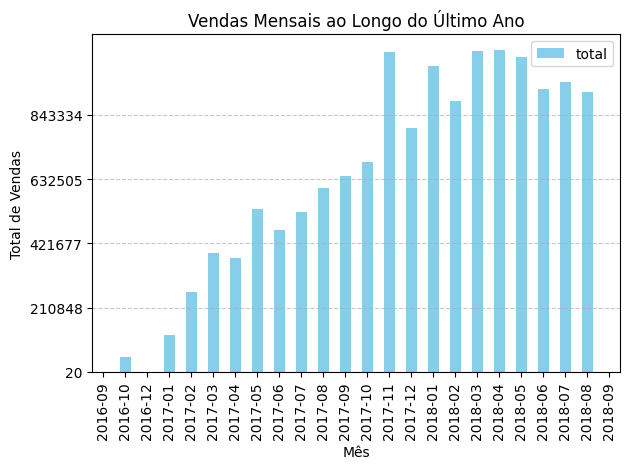

In [22]:
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar', color='skyblue', x='year_month')
plt.title('Vendas Mensais ao Longo do Último Ano')
plt.xlabel('Mês')
plt.ylabel('Total de Vendas')
plt.yticks(np.arange(min_value, max_value, interval))
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
order_seller = sellers.merge(order_items, on='seller_id')
order_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89


In [24]:
order_seller = order_seller.drop_duplicates('order_id')

In [25]:
order_seller['total'] = order_seller['price'] + order_seller['freight_value']

In [26]:
seller_receipt = group_sum(order_seller, 'seller_id', 'total')
seller_receipt.head()

,seller_id,total
0,0015a82c2db000af6aaaf3ae2ecb0532,2748.06
1,001cca7ae9ae17fb1caed9dfb1094831,28544.74
2,001e6ad469a905060d959994f1b41e4f,267.94
3,002100f778ceb8431b7a1020ff7ab48f,1908.66
4,003554e2dce176b5555353e4f3555ac8,139.38


In [27]:
seller_receipt_order = top_bottom(seller_receipt, 'total', 5, 5)
seller_receipt_order

,seller_id,total
852,4869f7a5dfa277a7dca6462dcf3b52b2,242362.20
1008,53243585a1d6dc2643021fd1853d8905,219949.85
876,4a3ca9315b744ce9f8e9374361493884,205624.63
3013,fa1c13f2614d7b5c4749cbc52fecda94,203700.37
1553,7e93a43ef30c4f03f38b393420bc753a,182017.96
38,0336182e1b3e92f029d5354832045fdf,19.16
1364,702835e4b785b67a084280efca355756,18.56
864,4965a7002cca77301c82d3f91b82e1a9,16.36
1458,77128dec4bec4878c37ab7d6169d6f26,15.22
2509,cf6f6bc4df3999b9c6440f124fb2f687,12.22


In [28]:
seller_quantity = group_unique(order_seller, 'seller_id', 'order_id')
seller_quantity.head()

,seller_id,order_id
0,0015a82c2db000af6aaaf3ae2ecb0532,3
1,001cca7ae9ae17fb1caed9dfb1094831,200
2,001e6ad469a905060d959994f1b41e4f,1
3,002100f778ceb8431b7a1020ff7ab48f,51
4,003554e2dce176b5555353e4f3555ac8,1


In [29]:
seller_quantity_order = top_bottom(seller_quantity, 'order_id', 5, 5)
seller_quantity_order

,seller_id,order_id
1229,6560211a19b47992c3666cc44a7e94c0,1846
876,4a3ca9315b744ce9f8e9374361493884,1716
2471,cc419e0650a3c5ba77189a1882b7556a,1704
367,1f50f920176fa81dab994f9023523100,1401
2633,da8622b14eb17ae2831f4ac5b9dab84a,1290
2507,cf281cf8b7affbdfe751b29cc85580e1,1
1845,97e50a621f8e801f4baf69e08687c192,1
2509,cf6f6bc4df3999b9c6440f124fb2f687,1
1154,5e25c632f9db6cfb8bc100421c2737b6,1
1485,7963e546f34e098b578f9ad102494601,1


In [30]:
max_value, min_value, interval = min_max(seller_receipt_order, 'total')

<Figure size 1000x600 with 0 Axes>

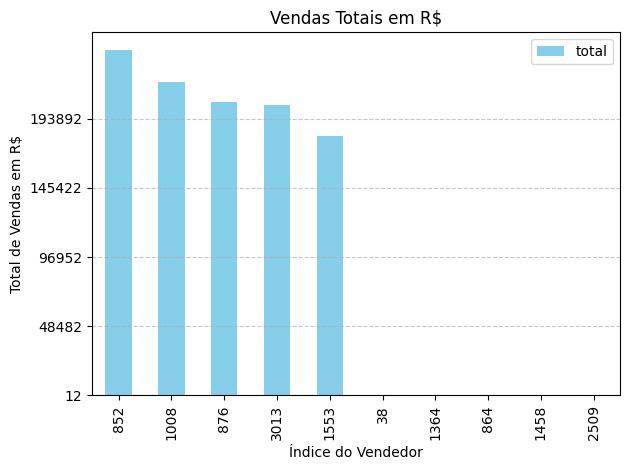

In [31]:
plt.figure(figsize=(10, 6))
seller_receipt_order.plot(kind='bar', color='skyblue')
plt.title('Vendas Totais em R$')
plt.xlabel('Índice do Vendedor')
plt.ylabel('Total de Vendas em R$')
plt.yticks(np.arange(min_value, max_value, interval))
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
max_value, min_value, interval = min_max(seller_quantity_order, 'order_id')

<Figure size 1000x600 with 0 Axes>

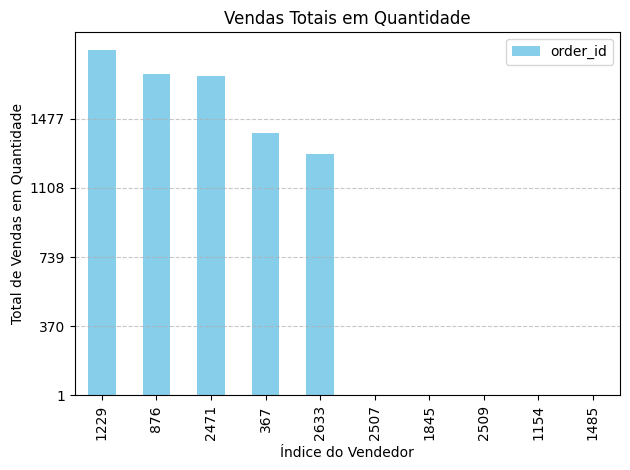

In [33]:
plt.figure(figsize=(10, 6))
seller_quantity_order.plot(kind='bar', color='skyblue')
plt.title('Vendas Totais em Quantidade')
plt.xlabel('Índice do Vendedor')
plt.ylabel('Total de Vendas em Quantidade')
plt.yticks(np.arange(min_value, max_value, interval))
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [35]:
product_count = order_items.merge(products, on='product_id')
product_count.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0


In [36]:
product_quantity = group_unique(product_count, 'product_id', 'order_id')
product_quantity_top_bottom = top_bottom(product_quantity, 'order_id', 5, 5)
product_quantity_top_bottom

,product_id,order_id
19742,99a4788cb24856965c36a24e339b6058,467
22112,aca2eb7d00ea1a7b8ebd4e68314663af,431
8613,422879e10f46682990de24d770e7f83d,352
27039,d1c427060a0f73f6b889a5c7c61f2ac4,323
7364,389d119b48cf3043d311335e499d9c6b,311
13692,69c58bb97c8d7b75fad9e6c1d391fda6,1
13691,69c3a9ec3f1094ad11505df27ddad569,1
13690,69c2f05e34d543dc71cfe745bfac8499,1
13689,69c2cca014581e7e3756142963a69313,1
32950,fffe9eeff12fcbd74a2f2b007dde0c58,1


In [37]:
product_quantity_category = product_quantity_top_bottom.merge(products[['product_id', 'product_category_name']], on='product_id')
product_quantity_category

,product_id,order_id,product_category_name
0,99a4788cb24856965c36a24e339b6058,467,cama_mesa_banho
1,aca2eb7d00ea1a7b8ebd4e68314663af,431,moveis_decoracao
2,422879e10f46682990de24d770e7f83d,352,ferramentas_jardim
3,d1c427060a0f73f6b889a5c7c61f2ac4,323,informatica_acessorios
4,389d119b48cf3043d311335e499d9c6b,311,ferramentas_jardim
5,69c58bb97c8d7b75fad9e6c1d391fda6,1,beleza_saude
6,69c3a9ec3f1094ad11505df27ddad569,1,beleza_saude
7,69c2f05e34d543dc71cfe745bfac8499,1,NaN
8,69c2cca014581e7e3756142963a69313,1,eletrodomesticos
9,fffe9eeff12fcbd74a2f2b007dde0c58,1,brinquedos


In [38]:
max_value, min_value, interval = min_max(product_quantity_category, 'order_id')

<Figure size 1000x600 with 0 Axes>

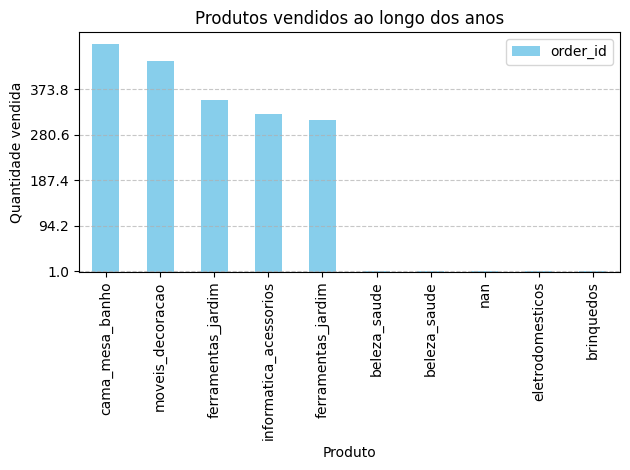

In [39]:
plt.figure(figsize=(10, 6))
product_quantity_category.plot(kind='bar', color='skyblue', x='product_category_name')
plt.title('Produtos vendidos ao longo dos anos')
plt.xlabel('Produto')
plt.ylabel('Quantidade vendida')
plt.yticks(np.arange(min_value, max_value, interval))
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Análise de Sentimento

In [40]:
def clean(text):
    if isinstance(text, str):
        text = text.lower()
        words = word_tokenize(text)
        words = [word for word in words if word not in stopwords.words('portuguese')]

        negation_words = set(["nada", "nunca", "sem", "nem", "não", "ninguém", 
                              "nenhum", "tampouco", "longe",
                              "proibido", "impossível", "falha", "errado", 
                              "desastroso", "decepcionante", "terrível",
                              "desagradável", "insatisfatório", "desanimador", 
                              "péssimo", "ruim", "desencorajador",
                              "péssimo", "desalentador", "desmotivante", 
                              "infelizmente", "negativo", "desfavorável",
                              "destrutivo", "desgostoso", "nota:0" , "nota:1", 
                              "nota:2"])


        appreciation_words = set(["incrível", "espetacular", "fenomenal", 
                                  "fabuloso", "genial", "radiante",
                                  "otimista", "inspirador", "encantador", 
                                  "fascinante", "deslumbrante", "empolgante",
                                  "fantástico", "excelente", "maravilhoso", 
                                  "surpreendente", "magnífico", "estupendo",
                                  "agradável", "delicioso", "prazeroso", 
                                  "incrível", "empolgante", "esplêndido",
                                  "deslumbrante", "extraordinário", 
                                  "cativante", "emocionante", "memorável", 
                                  "excepcional", "nota:3", "nota:4", "nota:5"])
        
        negated = False

        processed_words = []

        for word in words:

            if word in negation_words:
                negated = not negated
                word = "NOT_" + word
            elif word in appreciation_words:
                word = "APPRECIATION_" + word

            processed_words.append(word)

        cleaned_text = ' '.join(processed_words)
        return cleaned_text
    else:
        return np.nan
    

def clean_words(text):

    text = re.sub(r'APPRECIATION_|NOT_|nota:\d+', '', text)

    text = text.translate(str.maketrans('', '', string.punctuation))
    return text


def analyze(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return 0.0


def map_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

In [41]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [42]:
reviews = reviews.dropna(subset=['review_score', 'review_comment_message'])
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99215,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43


In [43]:
reviews['combined_text'] = 'nota:' + reviews['review_score']\
                           .astype(str) + \
                           ' ' + reviews['review_comment_message']

reviews.drop(['review_comment_message'], axis=1, inplace=True)

reviews.head()

,review_id,order_id,review_score,review_comment_title,review_creation_date,review_answer_timestamp,combined_text
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,2017-04-21 00:00:00,2017-04-21 22:02:06,nota:5 Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,2018-03-01 00:00:00,2018-03-02 10:26:53,nota:5 Parabéns lojas lannister adorei comprar...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,2018-05-22 00:00:00,2018-05-23 16:45:47,nota:4 aparelho eficiente. no site a marca do ...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,2018-02-16 00:00:00,2018-02-20 10:52:22,"nota:4 Mas um pouco ,travando...pelo valor ta ..."
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,2018-05-23 00:00:00,2018-05-24 03:00:01,"nota:5 Vendedor confiável, produto ok e entreg..."


In [44]:
reviews['cleaned_review'] = reviews['combined_text'].apply(clean)

reviews.cleaned_review

3        APPRECIATION_nota:5 recebi bem antes prazo est...
4        APPRECIATION_nota:5 parabéns lojas lannister a...
9        APPRECIATION_nota:4 aparelho eficiente . site ...
12       APPRECIATION_nota:4 pouco , travando ... valor...
15       APPRECIATION_nota:5 vendedor confiável , produ...
                               ...                        
99205    APPRECIATION_nota:4 produto recebi acordo comp...
99208    APPRECIATION_nota:5 entregou dentro prazo . pr...
99215    APPRECIATION_nota:3 produto enviado nf , exist...
99221    APPRECIATION_nota:5 APPRECIATION_excelente moc...
99223    NOT_nota:1 produto chegou ja devolver , pois d...
Name: cleaned_review, Length: 40977, dtype: object

In [45]:
reviews['sentiment_score'] = reviews['cleaned_review'].apply(analyze)
reviews.sentiment_score

3        0.000
4        0.000
9        0.000
12       0.000
15       0.500
         ...  
99205    0.000
99208    0.000
99215    0.000
99221    0.375
99223    0.000
Name: sentiment_score, Length: 40977, dtype: float64

In [46]:
reviews['sentiment_category'] = reviews['sentiment_score'].apply(map_sentiment)
reviews.sentiment_category                               

3         neutral
4         neutral
9         neutral
12        neutral
15       positive
           ...   
99205     neutral
99208     neutral
99215     neutral
99221    positive
99223     neutral
Name: sentiment_category, Length: 40977, dtype: object

In [47]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_creation_date,review_answer_timestamp,combined_text,cleaned_review,sentiment_score,sentiment_category
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,2017-04-21 00:00:00,2017-04-21 22:02:06,nota:5 Recebi bem antes do prazo estipulado.,APPRECIATION_nota:5 recebi bem antes prazo est...,0.0,neutral
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,2018-03-01 00:00:00,2018-03-02 10:26:53,nota:5 Parabéns lojas lannister adorei comprar...,APPRECIATION_nota:5 parabéns lojas lannister a...,0.0,neutral
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,2018-05-22 00:00:00,2018-05-23 16:45:47,nota:4 aparelho eficiente. no site a marca do ...,APPRECIATION_nota:4 aparelho eficiente . site ...,0.0,neutral
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,2018-02-16 00:00:00,2018-02-20 10:52:22,"nota:4 Mas um pouco ,travando...pelo valor ta ...","APPRECIATION_nota:4 pouco , travando ... valor...",0.0,neutral
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,2018-05-23 00:00:00,2018-05-24 03:00:01,"nota:5 Vendedor confiável, produto ok e entreg...","APPRECIATION_nota:5 vendedor confiável , produ...",0.5,positive


In [48]:
sentiment_analysis = reviews.groupby(['review_score', 'sentiment_category'])\
                     .size().unstack(fill_value=0).reset_index()

sentiment_analysis.set_index('review_score', inplace=True)
sentiment_analysis.head(10)

sentiment_category,negative,neutral,positive
review_score,,,
1,228,8277,240
2,36,2031,78
3,46,3332,179
4,45,5508,423
5,140,18261,2153


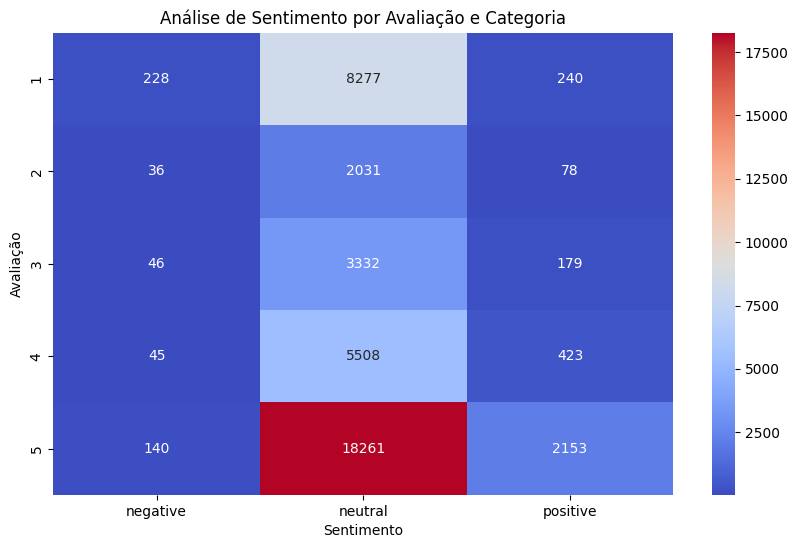

In [49]:
plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_analysis[['negative', 'neutral', 'positive']], cmap='coolwarm', annot=True, fmt='d')
plt.xlabel('Sentimento')
plt.ylabel('Avaliação')
plt.title('Análise de Sentimento por Avaliação e Categoria')
plt.show()

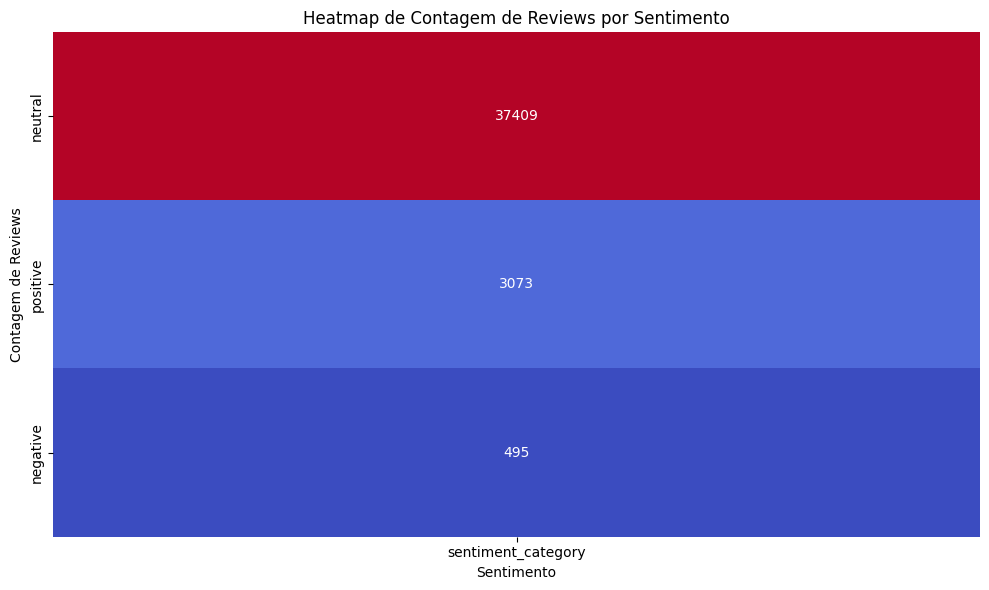

In [50]:
sentiment_counts = reviews['sentiment_category'].value_counts()

plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_counts.to_frame(), annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Heatmap de Contagem de Reviews por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Contagem de Reviews')
plt.tight_layout()
plt.show()

In [51]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02


In [52]:
orders_freight = orders.merge(order_items, on='order_id')

In [53]:
orders_freight.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [54]:
orders_freight.drop(columns=['product_id', 'seller_id', 'order_approved_at', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'order_item_id'], inplace=True)

In [55]:
orders_freight_review_score = orders_freight.merge(reviews, on='order_id')
orders_freight_review_score.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,year_month,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_creation_date,review_answer_timestamp,combined_text,cleaned_review,sentiment_score,sentiment_category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10,2017-10-06 11:07:15,29.99,8.72,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,2017-10-11 00:00:00,2017-10-12 03:43:48,"nota:4 Não testei o produto ainda, mas ele vei...","APPRECIATION_nota:4 testei produto ainda , vei...",0.0,neutral
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-07,2018-07-30 03:24:27,118.70,22.76,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,2018-08-08 00:00:00,2018-08-08 18:37:50,nota:4 Muito bom o produto.,APPRECIATION_nota:4 bom produto .,0.0,neutral
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-11,2017-11-23 19:45:59,45.00,27.20,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,2017-12-03 00:00:00,2017-12-05 19:21:58,nota:5 O produto foi exatamente o que eu esper...,APPRECIATION_nota:5 produto exatamente esperav...,0.0,neutral
3,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,NaN,2017-04,2017-04-19 13:25:17,49.90,16.05,e07549ef5311abcc92ba1784b093fb56,2,NaN,2017-05-13 00:00:00,2017-05-13 20:25:42,nota:2 fiquei triste por n ter me atendido.,NOT_nota:2 fiquei triste n ter atendido .,0.0,neutral
4,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-29 11:18:31,2017-05,2017-05-22 19:50:18,99.00,30.53,15898b543726a832d4137fbef5d1d00e,1,NaN,2017-05-30 00:00:00,2017-05-30 23:13:47,nota:1 Aguardando retorno da loja,NOT_nota:1 aguardando retorno loja,0.0,neutral


In [56]:
orders_freight_review_score['order_purchase_timestamp'] = pd.to_datetime(
    orders_freight_review_score['order_purchase_timestamp']
)

orders_freight_review_score['order_delivered_customer_date'] = pd.to_datetime(
    orders_freight_review_score['order_delivered_customer_date']
)

In [57]:
orders_freight_review_score['delivery_time'] = orders_freight_review_score['order_delivered_customer_date'] - orders_freight_review_score['order_purchase_timestamp']
orders_freight_review_score['delivery_hours'] = orders_freight_review_score['delivery_time'].dt.total_seconds() / 3600

In [58]:
orders_freight_review_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47292 entries, 0 to 47291
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       47292 non-null  object         
 1   customer_id                    47292 non-null  object         
 2   order_status                   47292 non-null  object         
 3   order_purchase_timestamp       47292 non-null  datetime64[ns] 
 4   order_delivered_customer_date  46130 non-null  datetime64[ns] 
 5   year_month                     47292 non-null  period[M]      
 6   shipping_limit_date            47292 non-null  object         
 7   price                          47292 non-null  float64        
 8   freight_value                  47292 non-null  float64        
 9   review_id                      47292 non-null  object         
 10  review_score                   47292 non-null  int64          
 11  re

In [59]:
orders_freight_review_score.dropna(subset=['review_score', 'delivery_hours'], inplace=True)
orders_freight_review_score = orders_freight_review_score.loc[orders_freight_review_score['order_status'] == 'delivered']

In [60]:
orders_freight_review_score.drop(columns=['review_comment_title'], inplace=True)

In [61]:
orders_freight_review_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46130 entries, 0 to 47291
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       46130 non-null  object         
 1   customer_id                    46130 non-null  object         
 2   order_status                   46130 non-null  object         
 3   order_purchase_timestamp       46130 non-null  datetime64[ns] 
 4   order_delivered_customer_date  46130 non-null  datetime64[ns] 
 5   year_month                     46130 non-null  period[M]      
 6   shipping_limit_date            46130 non-null  object         
 7   price                          46130 non-null  float64        
 8   freight_value                  46130 non-null  float64        
 9   review_id                      46130 non-null  object         
 10  review_score                   46130 non-null  int64          
 11  re

In [62]:
orders_freight_review_score.drop_duplicates(subset=['order_id'], inplace=True)

In [63]:
orders_freight_review_score.review_score.value_counts()

5    20373
1     7264
4     5900
3     3433
2     1987
Name: review_score, dtype: int64

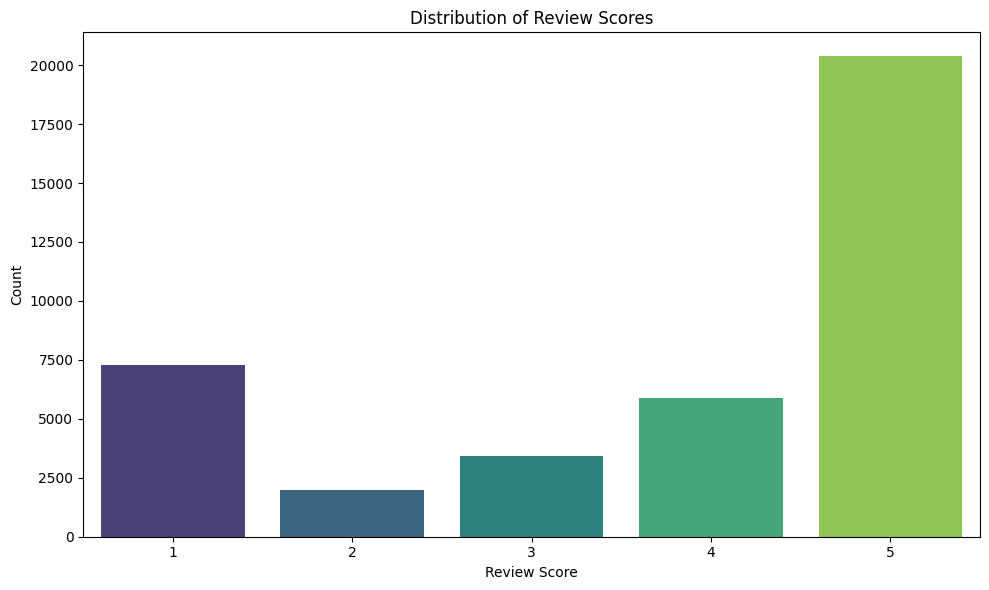

In [64]:
plt.figure(figsize=(10, 6))
sns.countplot(x='review_score', data=orders_freight_review_score, palette='viridis')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')
plt.tight_layout()
plt.show()

Pearson correlation coefficient: -0.3339386306172626
                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4889.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:22:44   Log-Likelihood:                -70365.
No. Observations:               38957   AIC:                         1.407e+05
Df Residuals:                   38955   BIC:                         1.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

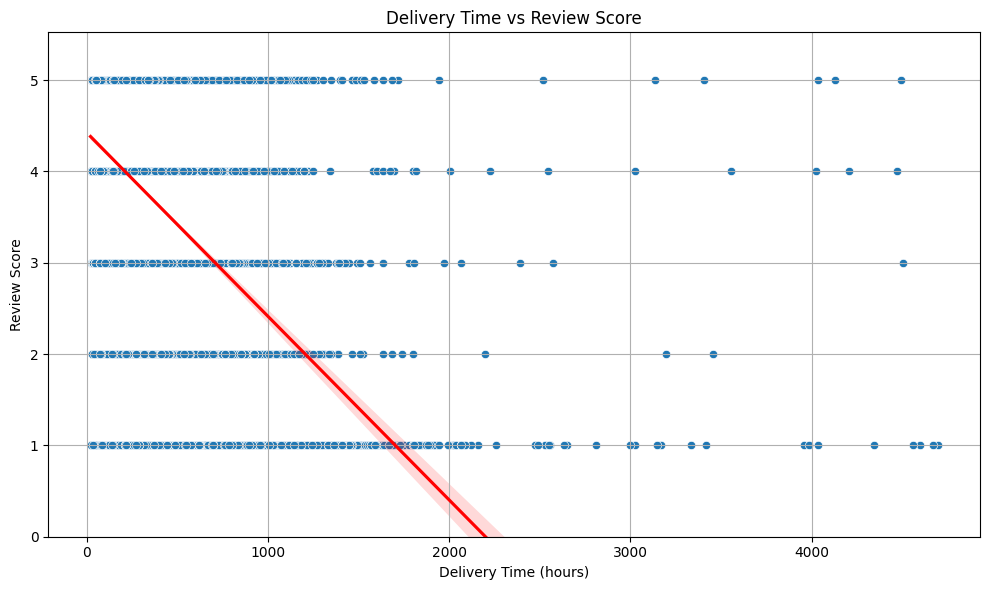

In [65]:
corr_coefficient, p_value = pearsonr(orders_freight_review_score['delivery_hours'], orders_freight_review_score['review_score'])
print("Pearson correlation coefficient:", corr_coefficient)

X = sm.add_constant(orders_freight_review_score['delivery_hours'])
y = orders_freight_review_score['review_score']

model = sm.OLS(y, X).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_hours', y='review_score', data=orders_freight_review_score)
sns.regplot(x='delivery_hours', y='review_score', data=orders_freight_review_score, scatter=False, color='red')
plt.xlabel('Delivery Time (hours)')
plt.ylabel('Review Score')
plt.title('Delivery Time vs Review Score')
plt.grid(True)
plt.ylim(0, None)
plt.tight_layout()
plt.show()

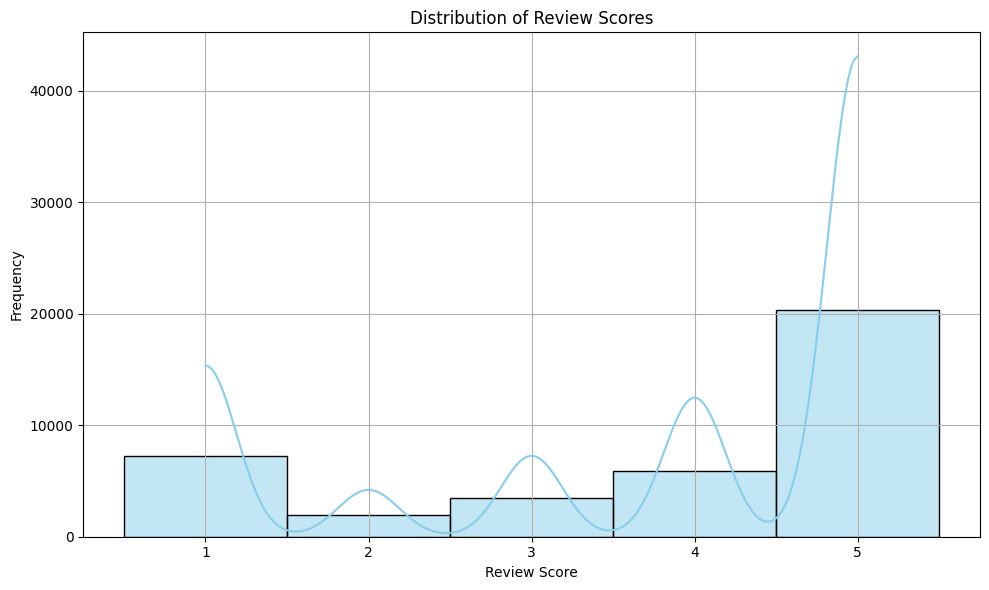

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(orders_freight_review_score['review_score'], bins=10, kde=True, color='skyblue', discrete=True)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

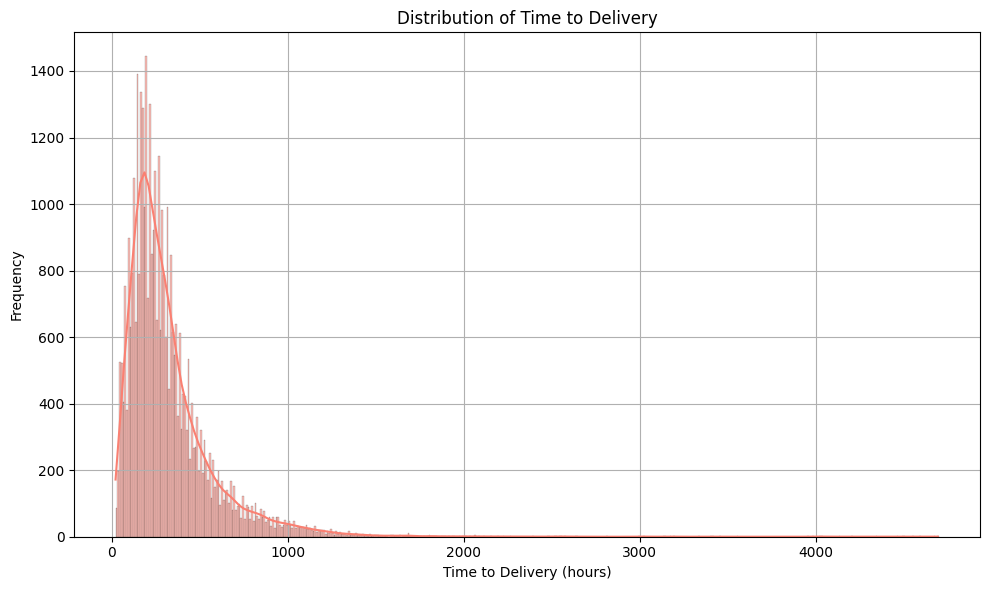

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(orders_freight_review_score['delivery_hours'], bins=10, kde=True, color='salmon', binwidth=10)
plt.title('Distribution of Time to Delivery')
plt.xlabel('Time to Delivery (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
reviews[['cleaned_review', 'sentiment_category', 'review_score']]

,cleaned_review,sentiment_category,review_score
3,APPRECIATION_nota:5 recebi bem antes prazo est...,neutral,5
4,APPRECIATION_nota:5 parabéns lojas lannister a...,neutral,5
9,APPRECIATION_nota:4 aparelho eficiente . site ...,neutral,4
12,"APPRECIATION_nota:4 pouco , travando ... valor...",neutral,4
15,"APPRECIATION_nota:5 vendedor confiável , produ...",positive,5
...,...,...,...
99205,APPRECIATION_nota:4 produto recebi acordo comp...,neutral,4
99208,APPRECIATION_nota:5 entregou dentro prazo . pr...,neutral,5
99215,"APPRECIATION_nota:3 produto enviado nf , exist...",neutral,3
99221,APPRECIATION_nota:5 APPRECIATION_excelente moc...,positive,5


C:\Users\rlope\AppData\Local\Temp\ipykernel_14924\2302230244.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  positive_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'positive')]['cleaned_review'].str.replace('APPRECIATION_', '').str.replace('NOT_', '').str.replace('nota:\d+', ''))
C:\Users\rlope\AppData\Local\Temp\ipykernel_14924\2302230244.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  negative_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'negative')]['cleaned_review'].str.replace('APPRECIATION_', '').str.replace('NOT_', '').str.replace('nota:\d+', ''))
C:\Users\rlope\AppData\Local\Temp\ipykernel_14924\2302230244.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  neutral_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'neutral')]['cleaned_review'].str.replace('APPRECIATION_', '').str.r

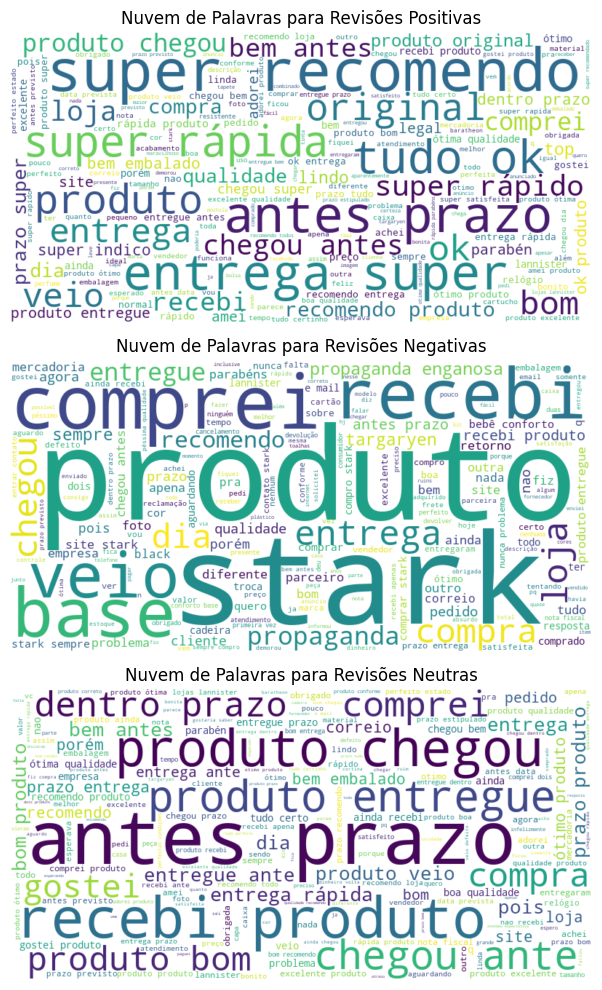

In [69]:
positive_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'positive')]['cleaned_review'].str.replace('APPRECIATION_', '').str.replace('NOT_', '').str.replace('nota:\d+', ''))
negative_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'negative')]['cleaned_review'].str.replace('APPRECIATION_', '').str.replace('NOT_', '').str.replace('nota:\d+', ''))
neutral_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'neutral')]['cleaned_review'].str.replace('APPRECIATION_', '').str.replace('NOT_', '').str.replace('nota:\d+', ''))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Nuvem de Palavras para Revisões Positivas')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Nuvem de Palavras para Revisões Negativas')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Nuvem de Palavras para Revisões Neutras')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
positive_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'positive')]['cleaned_review'].apply(clean_words)).split()
negative_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'negative')]['cleaned_review'].apply(clean_words)).split()
neutral_reviews = ' '.join(reviews[(reviews['sentiment_category'] == 'neutral')]['cleaned_review'].apply(clean_words)).split()

positive_word_counts = Counter(positive_reviews)
negative_word_counts = Counter(negative_reviews)
neutral_word_counts = Counter(neutral_reviews)

top_positive_words = positive_word_counts.most_common(50)
top_negative_words = negative_word_counts.most_common(50)
top_neutral_words = neutral_word_counts.most_common(50)

print("Palavras mais frequentes em revisões positivas:")
for word, count in top_positive_words:
    print(f"{word}: {count}")

print("\nPalavras mais frequentes em revisões negativas:")
for word, count in top_negative_words:
    print(f"{word}: {count}")

print("\nPalavras mais frequentes em revisões neutras:")
for word, count in top_neutral_words:
    print(f"{word}: {count}")

Agora refazendo a análise utilizando NLP

In [71]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.models import load_model
from sklearn.model_selection import train_test_split

In [72]:
review_nlp = pd.read_csv('olist_order_reviews_dataset.csv')
review_nlp.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [73]:
review_nlp.dropna(subset=['review_comment_message'], inplace=True)
sentences = review_nlp['review_comment_message'].tolist()
labels = review_nlp['review_score'].apply(lambda score: 1 if score > 3 else 0).tolist()
labels = np.array(labels)

In [74]:
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [75]:
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, maxlen=100, truncating='post').tolist()
padded_sequences = np.array(padded_sequences)

In [76]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=16, input_length=100),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [77]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(padded_sequences, labels, epochs=10, validation_split=0.2)


Epoch 1/10


1025/1025 [==============================] - 38s 34ms/step - loss: 0.3319 - accuracy: 0.8656 - val_loss: 0.2883 - val_accuracy: 0.8890
Epoch 2/10
1025/1025 [==============================] - 31s 30ms/step - loss: 0.2828 - accuracy: 0.8928 - val_loss: 0.2826 - val_accuracy: 0.8921
Epoch 3/10
1025/1025 [==============================] - 30s 30ms/step - loss: 0.2658 - accuracy: 0.9019 - val_loss: 0.2806 - val_accuracy: 0.8946
Epoch 4/10
1025/1025 [==============================] - 31s 30ms/step - loss: 0.2588 - accuracy: 0.9047 - val_loss: 0.2803 - val_accuracy: 0.8921
Epoch 5/10
1025/1025 [==============================] - 31s 30ms/step - loss: 0.2541 - accuracy: 0.9062 - val_loss: 0.2766 - val_accuracy: 0.8940
Epoch 6/10
1025/1025 [==============================] - 31s 30ms/step - loss: 0.2475 - accuracy: 0.9092 - val_loss: 0.2688 - val_accuracy: 0.8969
Epoch 7/10
1025/1025 [==============================] - 30s 30ms/step - loss: 0.2408 - accuracy: 0.9112 - val_loss: 0.269

In [78]:
import os
desktop_path = os.path.join(os.path.expanduser("~"))

model_save_path = os.path.join(desktop_path, 'saved_model')

model.save(model_save_path)

INFO:tensorflow:Assets written to: C:\Users\rlope\saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\rlope\saved_model\assets


In [79]:
loaded_model = load_model(model_save_path)

In [80]:
def classify_sentiment(prediction):
    if prediction < 0.4:  
        return 'Negativa'
    elif prediction < 0.6:
        return 'Neutra'
    else:
        return 'Positiva'

In [81]:
prediction = loaded_model.predict(padded_sequences)

1281/1281 [==============================] - 14s 10ms/step


In [82]:
review_nlp['sentiment_category'] = [classify_sentiment(pred) for pred in prediction]

In [83]:
review_nlp.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sentiment_category
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Positiva
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Positiva
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,Neutra
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,Positiva
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,Positiva


In [84]:
sentiment_analysis = review_nlp.groupby(['review_score', 'sentiment_category'])\
                     .size().unstack(fill_value=0).reset_index()

sentiment_analysis.set_index('review_score', inplace=True)
sentiment_analysis.head(10)

sentiment_category,Negativa,Neutra,Positiva
review_score,,,
1,8340,173,232
2,1920,86,139
3,2327,274,956
4,802,484,4690
5,557,384,19613


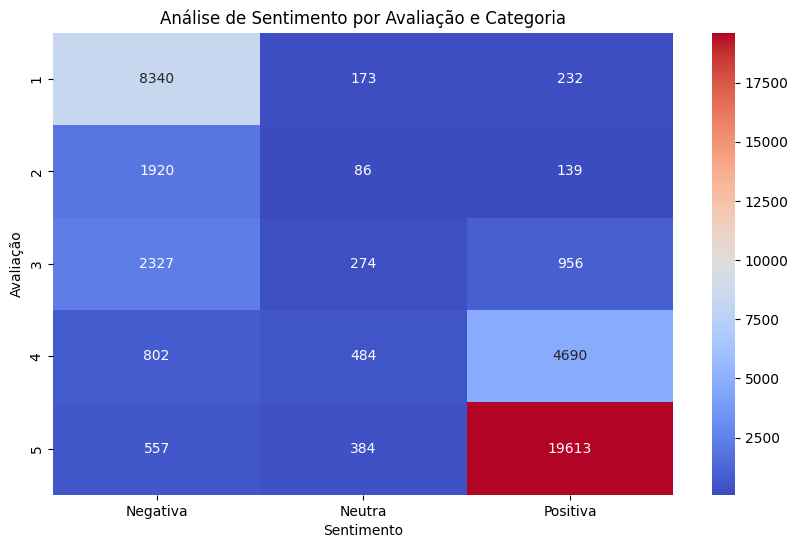

In [85]:
plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_analysis[['Negativa', 'Neutra', 'Positiva']], cmap='coolwarm', annot=True, fmt='d')
plt.xlabel('Sentimento')
plt.ylabel('Avaliação')
plt.title('Análise de Sentimento por Avaliação e Categoria')
plt.show()

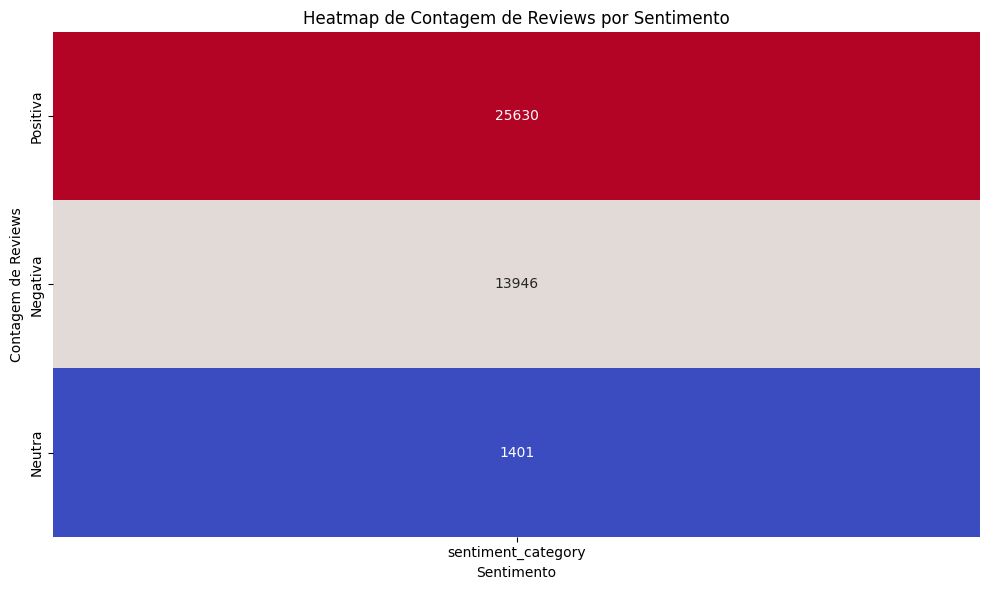

In [86]:
sentiment_counts = review_nlp['sentiment_category'].value_counts()

plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_counts.to_frame(), annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Heatmap de Contagem de Reviews por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Contagem de Reviews')
plt.tight_layout()
plt.show()